# Anomaly detection

## Imports and functions

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from functools import partial
import re
import os

from tensorflow.keras import models

In [2]:
def load_files_list(directory):
    '''
    Load the audiofiles inside a directory.
    '''
    return os.listdir(directory)

## Loading the model

In [6]:
model = keras.models.load_model('baseline_slider_allids.h5')
model.trainable = False

## Loading the dataset with anomalies

In [7]:
DIRECTORY = '/home/belen_alastruey/PYTHON/Autoencoder/'

In [8]:
anomalies_path = DIRECTORY + 'MEL_ANOMALY/'

In [9]:
files = load_files_list(anomalies_path)

### Read .npy

In [10]:
descriptors_anomalies = []
labels = []
for file in files:
    if ("slider" in file) and ('abnormal'in file):
        descr = np.load(anomalies_path + file)
        descriptors_anomalies.append(descr)
        labels.append(re.split(r'_', file)[1])

In [11]:
descr = np.asarray(descriptors_anomalies)
labels = np.asarray(labels)

In [12]:
descr.shape

(356, 128, 216)

In [13]:
descr_anomaly = descr
label_anomaly = labels

## Loading the dataset without anomalies

In [14]:
DIRECTORY = '/home/belen_alastruey/PYTHON/Autoencoder/'

In [15]:
path = DIRECTORY + 'MEL/'

In [16]:
files = load_files_list(path)

### Read .npy

In [17]:
descriptors_normal= []
for file in files:
    if "slider_id00" in file:
        descr = np.load(path + file)
        descriptors_normal.append(descr)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
do_not_use, descr = train_test_split(descriptors_normal,test_size=0.15, random_state=100)

In [20]:
descr = np.asarray(descr)
labels = np.zeros(descr.shape[0])

In [21]:
descr.shape

(161, 128, 216)

## Create X_train

In [22]:
X_train = np.concatenate((descr, descr_anomaly), axis = 0)
y_train = np.concatenate((labels ,label_anomaly), axis = 0)

In [23]:
y_train

array(['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0',

In [24]:
randomize = np.arange(len(X_train))
np.random.shuffle(randomize)
X_train = X_train[randomize]
y_train = y_train[randomize]

### Transformations

#### X_train

In [22]:
inputs = []
for n in range(X_train.shape[0]):
    for i in range(211):
        a = []
        a.append([X_train[n,:,i],X_train[n,:,i+1],X_train[n,:,i+2],X_train[n,:,i+3],X_train[n,:,i+4]])
        a = np.asarray(a)
        a = a.reshape(640)
        inputs.append(a)

In [23]:
inputs = np.asarray(inputs)

In [24]:
inputs.shape

(117949, 640)

### Predictions

In [25]:
pred = model.predict(inputs)

In [26]:
inputs.shape

(117949, 640)

In [27]:
pred.shape

(117949, 640)

### Getting the reconstruction error

In [28]:
pred2 = pred
inputs2 = inputs

#### (IGNORAR) Difference + mean

In [18]:
error =[]

In [110]:
#DO NOT USE
for i in range(X_train.shape[0]):
    e = np.mean(pred2[:211]-inputs2[:211])
    error.append(e)
    pred2 = pred2[211:]
    inputs2 = inputs2[211:]

In [111]:
error = np.asarray(error)

In [112]:
error.shape

(996,)

#### As in the article

In [29]:
error = [] #llsta amb un error per cada imatge

In [30]:
for i in range(X_train.shape[0]):
    valors_sumar = []
    for j in range(211):
        e = np.linalg.norm(pred2[j]-inputs2[j], ord = 2)
        valors_sumar.append(e)
    pred2 = pred2[211:]
    inputs2 = inputs2[211:]
    error.append((sum(valors_sumar)/(640*211)))

In [31]:
error = np.asarray(error)

In [32]:
error.shape

(559,)

### Plots


In [33]:
from matplotlib import pyplot as plt

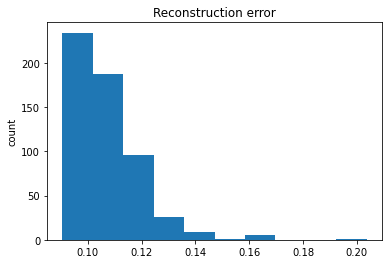

In [34]:
#tots els errors
plt.hist(error)
plt.title('Reconstruction error')
plt.ylabel('count')

plt.show()

In [35]:
errors_normal = []
errors_abnormal = []
for e, label in zip(error, y_train):
    if label == 'abnormal':
        errors_abnormal.append(e)
    else:
        errors_normal.append(e)

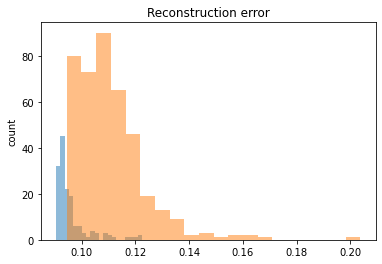

In [36]:
plt.hist(errors_normal,bins=20, alpha=0.5)
plt.hist(errors_abnormal,bins=20, alpha=0.5)
plt.title('Reconstruction error')
plt.ylabel('count')

plt.show()

## AUC

In [37]:
y_train2 = np.zeros(X_train.shape[0])

In [38]:
for i in range(len(y_train2)):
    if y_train[i] == 'abnormal':
        y_train2[i] = 1

In [39]:
y_train2.shape

(559,)

In [40]:
import numpy as np
from sklearn import metrics

In [41]:
y_train2=[float(i) for i in y_train2]
y_train2 = np.asarray(y_train2)

## AUC amb la funcio de sklearn

In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y_train2, error)

In [43]:
metrics.auc(fpr, tpr)

0.9169145221776802

## AUC manual com al article

In [44]:
c = 0

In [45]:
for e_a in errors_abnormal:
    for e_n in errors_normal:
        c+= e_a > e_n
        
c = c/(len(errors_abnormal)*len(errors_normal))

In [46]:
c

0.9169145221776801